[1] P. Welch, “The use of the fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms”, IEEE Trans. Audio Electroacoust. vol. 15, pp. 70-73, 1967.

[2] Rabiner, Lawrence R., and B. Gold. “Theory and Application of Digital Signal Processing” Prentice-Hall, pp. 414-419, 1975

[3] M.S. Bartlett, “Periodogram Analysis and Continuous Spectra”, Biometrika, vol. 37, pp. 1-16, 1950.

###   Cross-Correlation vs. Convolution(Image)

$$
\begin{align}
G &= h \otimes F \\
G(i,j) &= \sum_{u=-k}^{k} \sum_{v=-k}^{k} h(u,v)F(i+u,j+v)
\end{align}
$$

$$
\begin{align}
G &= h \ast F \\
G(i,j) &= \sum_{u=-k}^{k} \sum_{v=-k}^{k} h(u,v)F(i-u,j-v)
\end{align}
$$

### Finite Impulse Response Convolution(Audio)

$$
y(n) = \sum_{k=0}^{M-1}h(k)x(n-k)
$$

In [1]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

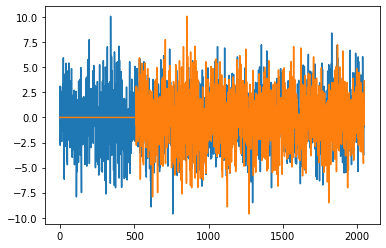

In [2]:
sr = 2048
length = sr * 2
latency= 512

data = np.random.normal(0, 5, length) * 0.5 + np.sin(25 * np.linspace(0, 2*np.pi, length))
y1 = data[:sr]
y2 = np.concatenate((np.zeros(latency), data[:sr-latency]))
plt.plot(y1)
plt.plot(y2)
plt.show()

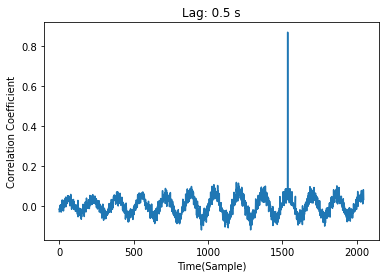

In [3]:
n = len(y1)

y_21 = signal.correlate(y2, y1, mode='same')
y_11 = signal.correlate(y1, y1, mode='same')
y_22 = signal.correlate(y2, y2, mode='same')

correlation = y_21 / np.sqrt(y_11[int(n/2)]  * y_22[int(n/2)])

plt.plot(correlation)
plt.title('Lag: ' + str((np.argmax(correlation) - int(n/2)) / int(n/2)) + ' s')
plt.xlabel('Time(Sample)')
plt.ylabel('Correlation Coefficient')
plt.show()

### Cross Spectrum Density

Cross spectrum is a complex-valued function, the cross spectrum can be estimated from the Fourier transforms of the two time series. In the frequency domain, we compute the cross spectrum as:

$$
\begin{align}
V_{XY}(n) 
&= V_{X}(n)V_{Y}^*(n) \\
&= L_{XY}(n) - iQ_{XY}(n) \\
\end{align}
$$

where $Z_{X}(n)$, $Z_{Y}(n)$ are the Fourier transforms of $x(n)$ and $y(n)$, and the asterisk indicates the complex conjugate. The real and imaginary parts, $L$ and $Q$, are the co-spectrum and quadrature spectrum. The cross spectrum can be expressed more usefully in polar form. 

$$
\begin{align}
V_{XY}(n) 
&= A_{XY}(n)e^{i\phi_{XY}(n)} \\
\end{align}
$$

The squared coherency is then a normalized amplitude, with $\phi$ the coherence phase. 

$$
\begin{align}
\gamma_{XY}^2(n) &= \frac{A_{XY}^2(n)}{A_{XX}(n)A_{YY}(n)} \\
\gamma_{XY}(n) &= \frac{A_{XY}(n)}{(A_{XX}(n)A_{YY}(n))^{(1/2)}}
\end{align}
$$

In Harman's patent, which adopt same fomular using complex form with absoulte arithmetic.

$$
\begin{align}
P &= (|V_L|^2+|V_R|^2)/2 \\
V_x &= |V_LV_R^*| \\
\rho_c &= \frac{V_x}{P} \\
\rho_c(n) &= (1-\alpha )\rho_c(n-1) + \alpha \rho_c(n) \\
Y_c &= (V_L + V_R) F(\rho_c(n))
\end{align}
$$

In [4]:
size = 256
rng = np.random.default_rng()
noise = rng.normal(scale=np.sqrt(0.01), size=size)

y1 = np.sin(32 * np.linspace(0, 2*np.pi, size)) + noise * 10
y2 = np.cos(10 * np.linspace(0, 2*np.pi, size))
win = signal.get_window("hann", size)
scale = 1.0 / (size * (win*win).sum())

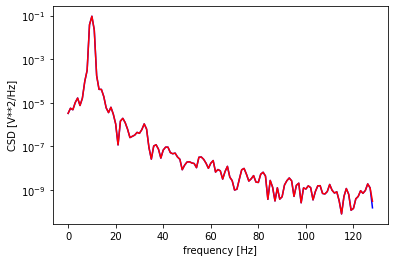

In [5]:
X = np.fft.rfft(y1 * win)
Y = np.fft.rfft(y2 * win)
XY = np.abs(X * np.conjugate(Y)) * scale
XY[1:] = XY[1:] * 2

f, Pxy = signal.csd(y1, y2, fs=size, window="hann", noverlap = 0, nperseg=size, detrend=False, return_onesided=True)
plt.semilogy(np.abs(Pxy), 'b')
plt.semilogy(XY, 'r')
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

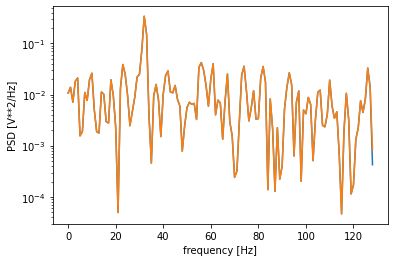

In [6]:
P_XY = np.abs(X * np.conjugate(X)) * scale
P_XY[1:] = P_XY[1:] * 2

f, Pxx_den = signal.welch(y1, fs=size, window="hann", noverlap = 0, nperseg=size, detrend=False, return_onesided=True)
plt.semilogy(Pxx_den)
plt.semilogy(P_XY)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

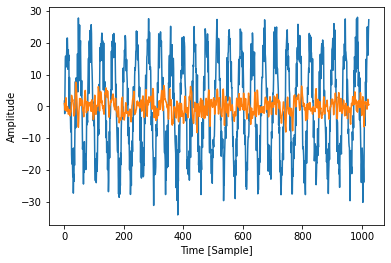

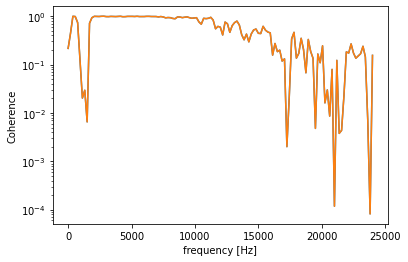

In [7]:
fs = 48000
N = 1024
amp = 20
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
b, a = signal.butter(2, 0.25, 'low')
x = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
y = signal.lfilter(b, a, x)
x += amp*np.sin(2*np.pi*freq*time)
y += rng.normal(scale=0.1*np.sqrt(noise_power), size=time.shape)

plt.plot(x)
plt.plot(y)
plt.xlabel('Time [Sample]')
plt.ylabel('Amplitude')
plt.show()

_, Pxy = signal.csd(x, y, fs, nperseg=256)
_, Pyy = signal.welch(y, fs, nperseg=256)
_, Pxx = signal.welch(x, fs, nperseg=256)

f, Cxy = signal.coherence(x, y, fs, nperseg=256)
plt.semilogy(f, Cxy)
plt.semilogy(f, np.abs(Pxy) ** 2 / Pxx / Pyy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()

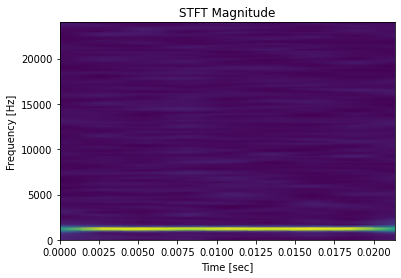

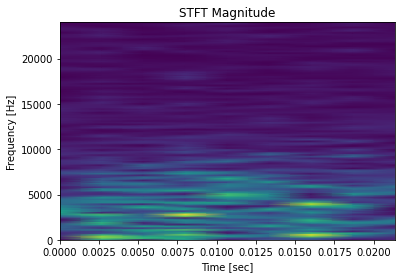

In [8]:
f, t, Zxx= signal.stft(x, fs, nperseg=256)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zyy = signal.stft(y, fs, nperseg=256)
plt.pcolormesh(t, f, np.abs(Zyy), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()